# METR-LA LSTM

This notebook is a step by step guide to train a simple LSTM to forecast METR-LA traffic speeds.

**Training Process:**
1. Load the dataset from a `.zip` (contains `METR-LA.h5`).
2. Turn the H5 store into a regular `pandas.DataFrame` (time x sensors).
3. Split into Train / Validation / Test.
4. Scale the data (fit only on Train).
5. Make sliding windows (last 12 steps → next 12 steps).
6. Define a tiny LSTM with PyTorch.
7. Train for a few epochs and check simple metrics.
8. Make a forecast and attach **real timestamps**.



## 1) Setup

- Change `DATA_ZIP_PATH` if your zip is elsewhere.
- The zip should contain `METR-LA.h5` (and optionally an adjacency file you can ignore here).


In [ ]:
import os, zipfile
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Change this if needed
#DATA_ZIP_PATH = "/mnt/data/archive (4).zip"
#WORKDIR = "./metr_simple"
DATA_ZIP_PATH = ""
WORKDIR = "/content/drive/MyDrive/CIS-583 Deep Learning/CIS-583 Deep Learning: The Fourcast Quarter/Assets/Datasets/METR-LA/metr_simple"
#WORKDIR = "../../Datasets/METR-LA/metr_simple"

os.makedirs(WORKDIR, exist_ok=True)

# Unzip once
if os.path.exists(DATA_ZIP_PATH):
    with zipfile.ZipFile(DATA_ZIP_PATH, 'r') as zf:
        zf.extractall(WORKDIR)

print("Files in WORKDIR:", os.listdir(WORKDIR))


Files in WORKDIR: []


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## 2) Load METR-LA into a DataFrame

- The H5 file is a pandas store. We'll read it with `h5py` so we can handle weird encodings.
- If timestamps don't decode cleanly, we **synthesize** a 5-minute time index (ordering is preserved).


In [ ]:
h5_path = os.path.join(WORKDIR, "METR-LA.h5")
assert os.path.exists(h5_path), "Couldn't find METR-LA.h5 inside the unzipped folder."

# Read raw arrays from the H5 store
with h5py.File(h5_path, "r") as h5:
    cols = h5["df/axis0"][()].astype(str)     # sensor IDs (columns)
    idx_raw = h5["df/axis1"][()]              # timestamps (often bytes)
    values = h5["df/block0_values"][()]       # data values (time x sensors)

# Decode timestamps to strings safely
def to_str(x):
    try:
        return x.decode("utf-8")
    except Exception:
        return str(x)

idx_str = np.array([to_str(s) for s in idx_raw])

# Try parsing to datetimes; otherwise synthesize a clean 5-minute index
def try_parse(s):
    for fmt in ("%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H:%M:%S.%f", "%m/%d/%Y %H:%M", "%Y-%m-%dT%H:%M:%S"):
        try:
            return pd.to_datetime(s, format=fmt)
        except Exception:
            pass
    return pd.NaT

dt_index = pd.to_datetime([try_parse(s) for s in idx_str])

df = pd.DataFrame(values, columns=cols)
if dt_index.isna().any():
    # fallback: 5-minute steps, same number of rows
    start = pd.Timestamp("2012-03-01 00:00:00")
    df.index = pd.date_range(start=start, periods=df.shape[0], freq="5min")
else:
    df.index = dt_index

print("Data shape (time, sensors):", df.shape)
df.head()


Data shape (time, sensors): (34272, 207)


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875
2012-03-01 00:10:00,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500,64.250,63.875000,65.375000,...,44.125000,69.000,56.500000,59.250000,68.125,62.500000,65.625000,61.375000,69.857143,62.000
2012-03-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
2012-03-01 00:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000


## 3) Split into Train / Validation / Test

- We'll use a simple **time-based split**: first 70% train, next 10% val, last 20% test.
- We also compute **mean** and **std** from train only (to avoid leakage) and scale all splits.


In [ ]:
T = len(df)
train_end = int(T * 0.7)
val_end   = int(T * 0.8)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

mean = train_df.mean()
std  = train_df.std().replace(0, 1.0)

train_z = (train_df - mean) / std
val_z   = (val_df - mean) / std
test_z  = (test_df - mean) / std

print(train_df.shape, val_df.shape, test_df.shape)


(23990, 207) (3427, 207) (6855, 207)


## 4) Build sliding windows (inputs and targets)

- We want to feed the LSTM the **last 12 timesteps** (1 hour of 5-min data) and predict the **next 12** timesteps.
- We do this for each split separately.


In [ ]:
INPUT_STEPS = 12   # 12 x 5min = 1 hour of history
OUTPUT_STEPS = 12  # predict next hour

class WindowDataset(Dataset):
    def __init__(self, data_2d, in_steps, out_steps):
        X_list, Y_list = [], []
        T, N = data_2d.shape
        last_start = T - (in_steps + out_steps)
        for s in range(last_start + 1):
            X_list.append(data_2d[s : s + in_steps])
            Y_list.append(data_2d[s + in_steps : s + in_steps + out_steps])
        self.X = torch.tensor(np.stack(X_list), dtype=torch.float32)  # (samples, in_steps, N)
        self.Y = torch.tensor(np.stack(Y_list), dtype=torch.float32)  # (samples, out_steps, N)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

train_ds = WindowDataset(train_z.values, INPUT_STEPS, OUTPUT_STEPS)
val_ds   = WindowDataset(val_z.values,   INPUT_STEPS, OUTPUT_STEPS)
test_ds  = WindowDataset(test_z.values,  INPUT_STEPS, OUTPUT_STEPS)

len(train_ds), len(val_ds), len(test_ds)


(23967, 3404, 6832)

## 5) Create DataLoaders

- DataLoaders give us mini-batches for faster training.


In [ ]:
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)


## 6) Define a small LSTM model

**Key idea:** each time step is a vector of all sensor speeds. We give the LSTM 12 of those vectors in sequence.  
The LSTM's last hidden state goes through a linear layer to produce 12 future vectors.


In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_size=64, num_layers=1, out_steps=12):
        super().__init__()
        self.num_sensors = num_sensors
        self.out_steps = out_steps
        self.lstm = nn.LSTM(input_size=num_sensors, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_steps * num_sensors)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]  # (batch, hidden)
        pred = self.fc(last)  # (batch, out_steps * sensors)
        return pred.view(-1, self.out_steps, self.num_sensors)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_sensors = df.shape[1]
model = SimpleLSTM(num_sensors, hidden_size=64, num_layers=1, out_steps=OUTPUT_STEPS).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

sum(p.numel() for p in model.parameters())


231348

## 7) Train (few epochs)

- We keep this loop **very short and simple**.
- Increase epochs later if you want better accuracy.


In [ ]:
def run_epoch(dloader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, total_count = 0.0, 0

    for X, Y in dloader:
        X = X.to(device); Y = Y.to(device)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            Yhat = model(X)
            loss = loss_fn(Yhat, Y)
            if train:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * X.size(0)
        total_count += X.size(0)
    return total_loss / total_count

EPOCHS = 50  # start small; you can raise this
for epoch in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader,   train=False)
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={tr:.4f} | val_loss={va:.4f}")


Epoch 1/500 | train_loss=0.2473 | val_loss=0.4542
Epoch 2/500 | train_loss=0.2398 | val_loss=0.4462
Epoch 3/500 | train_loss=0.2334 | val_loss=0.4009
Epoch 4/500 | train_loss=0.2312 | val_loss=0.4361
Epoch 5/500 | train_loss=0.2269 | val_loss=0.4356
Epoch 6/500 | train_loss=0.2283 | val_loss=0.4277
Epoch 7/500 | train_loss=0.2240 | val_loss=0.4137
Epoch 8/500 | train_loss=0.2233 | val_loss=0.4269
Epoch 9/500 | train_loss=0.2174 | val_loss=0.4674
Epoch 10/500 | train_loss=0.2157 | val_loss=0.4583
Epoch 11/500 | train_loss=0.2148 | val_loss=0.4902
Epoch 12/500 | train_loss=0.2166 | val_loss=0.4866
Epoch 13/500 | train_loss=0.2123 | val_loss=0.4870
Epoch 14/500 | train_loss=0.2122 | val_loss=0.4197
Epoch 15/500 | train_loss=0.2167 | val_loss=0.4521
Epoch 16/500 | train_loss=0.2092 | val_loss=0.4470
Epoch 17/500 | train_loss=0.2052 | val_loss=0.4327
Epoch 18/500 | train_loss=0.2093 | val_loss=0.4104
Epoch 19/500 | train_loss=0.2037 | val_loss=0.4363
Epoch 20/500 | train_loss=0.2024 | val_l

KeyboardInterrupt: 

## 8) Simple evaluation metrics (MAE / RMSE / MAPE)

We denormalize predictions back to original units (mph) using the **train** mean/std.


In [ ]:
def denorm(tensor_2d):
    m = torch.from_numpy(mean.values).to(tensor_2d.device)
    s = torch.from_numpy(std.values).to(tensor_2d.device)
    return tensor_2d * s + m

@torch.no_grad()
def evaluate(loader):
    model.eval()
    mae = rmse = mape = 0.0
    n = 0
    eps = 1e-5
    for X, Y in loader:
        X = X.to(device); Y = Y.to(device)
        Yhat = model(X)
        Y_dn = denorm(Y)
        Yh_dn = denorm(Yhat)
        abs_err = (Yh_dn - Y_dn).abs()
        mae  += abs_err.mean(dim=(1,2)).sum().item()
        rmse += torch.sqrt(((Yh_dn - Y_dn)**2).mean(dim=(1,2))).sum().item()
        mape += (abs_err / (Y_dn.abs() + eps)).mean(dim=(1,2)).sum().item()
        n += X.size(0)
    return {"MAE": mae/n, "RMSE": rmse/n, "MAPE": mape/n}

test_metrics = evaluate(test_loader)
test_metrics


{'MAE': 9.348548453531759,
 'RMSE': 13.146100731581928,
 'MAPE': 228684.59739617526}

## 9) Forecast with **real timestamps**

- Use the **last 12 rows** of your dataset (scaled) as the input window.
- Predict the next 12 rows and attach the correct future times (5-minute steps).


In [ ]:
# Build a recent input window from the full dataset (scaled)
recent_scaled = (df - mean) / std
window = recent_scaled.values[-INPUT_STEPS:]

x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 12, sensors)
with torch.no_grad():
    pred_scaled = model(x).squeeze(0)  # (12, sensors)

pred = denorm(pred_scaled).cpu().numpy()

# Build future timestamps
step = pd.Timedelta(minutes=5)
last_time = df.index[-1]
future_times = [last_time + step * (i+1) for i in range(OUTPUT_STEPS)]

pred_df = pd.DataFrame(pred, index=future_times, columns=df.columns)
print(pred_df.shape)
pred_df.head()


(12, 207)


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-06-28 00:00:00,47.882235,59.178459,61.016936,48.412259,42.842838,49.689388,55.639448,61.179733,63.976681,41.603070,...,40.448949,59.248934,61.053650,58.378473,64.175556,57.120505,65.141463,54.256767,55.744672,47.555215
2012-06-28 00:05:00,44.367722,54.893564,55.308461,45.245745,41.790566,46.345439,52.072832,57.081179,60.673980,39.363612,...,37.188547,55.761077,57.998566,53.976461,59.193630,52.692999,60.381353,50.725339,51.467787,45.068448
2012-06-28 00:10:00,43.748650,53.590850,52.720685,44.468746,42.865307,45.898088,51.424506,56.118005,59.888747,39.934721,...,35.973744,54.837258,56.958561,52.347428,57.129829,51.145032,59.013530,50.186474,49.881120,44.914960
2012-06-28 00:15:00,45.783570,54.667528,52.431072,46.074432,45.281603,47.206463,52.485694,57.159134,61.150885,42.591135,...,36.082847,56.640286,57.870642,53.006952,57.576617,51.843542,59.937741,51.873253,51.240946,46.672039
2012-06-28 00:20:00,47.542370,55.517999,51.699365,47.254917,47.870968,48.749950,53.553079,57.749455,62.034692,45.030504,...,36.090509,57.834186,58.813502,53.501041,57.659667,52.375844,60.516913,53.078828,52.259331,48.771584


## 10) Plot one sensor (history vs forecast)

Very simple visualization to show **what the model sees** and **what it predicts next**.


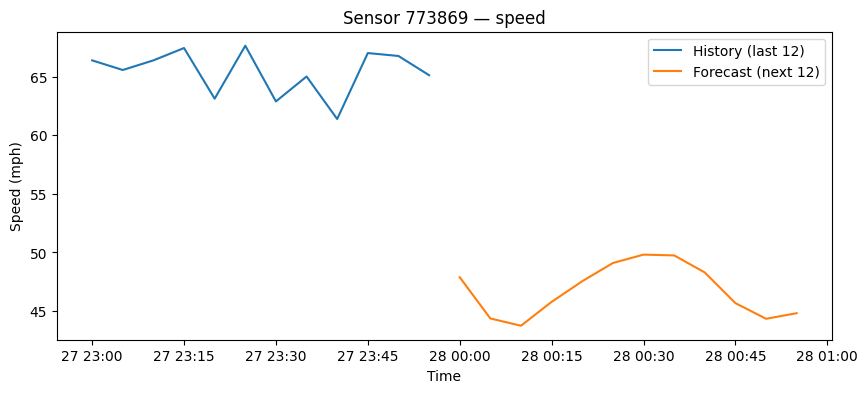

In [ ]:
sensor_id = df.columns[0]
hist_y = df[sensor_id].iloc[-INPUT_STEPS:]
fut_y  = pred_df[sensor_id]

plt.figure(figsize=(10,4))
plt.plot(hist_y.index, hist_y.values, label="History (last 12)")
plt.plot(fut_y.index, fut_y.values, label="Forecast (next 12)")
plt.title(f"Sensor {sensor_id} — speed")
plt.xlabel("Time")
plt.ylabel("Speed (mph)")
plt.legend()
plt.show()


## Notes / Talking Points

- **Why scale?** Many models train better when inputs are centered and scaled. We fit on **train** only to avoid peeking at the future.
- **Why sliding windows?** Time series models need sequences. We convert a long series into many (inputs → targets) pairs.
- **Why LSTM?** It can learn patterns over time steps. This is a simple baseline (no road graph).
- **How to improve?** Train longer, tune hidden size/layers, add early stopping.
